# COMPAS 

## Abstract
COMPAS er en algoritme utvikla for å anslå hvor trolig det er at en sikta person vil begå nye straffbare handlinger, og brukes utbredt i amerikansk rettvesen. Da nettavisen ProPublica i 2016 tok for seg ulike deler av algoritmen, synes det gjennomgående at algoritmen på bakgrunn av etnisitet ga hvite et lavere risikoanslag enn svarte. Derfor skal vi i denne analysen ta for oss ulike deler av algoritmen, og konsekvensene av dem.

# Lese inn og forstå dataene

Vi bruker Pandas til å lese inn dataene, og lager en `DataFrame` med de kolonnene vi er interessert i å se på. Her gjør vi også noen forenklinger:

 - Kolonnen `white` indikerer om personen er "hvit" eller ikke, hvor vi definerer hvit som gruppen ("race") "Caucasian" i det originale datasettet
 - Kolonnen `predicted` indikerer om personen er predikert til å begå nye lovbrudd
 - Kolonnen `actual` indikerer om personen faktisk begikk nye lovbrudd

In [1]:
import pandas as pd
import matplotlib.ticker as mtick
from IPython.core.display import display, HTML

def display_df_pct(df):
    display(HTML(df.to_html(float_format=lambda x: f'{x*100:.1f}%')))

data = pd.read_csv("../data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]

In [2]:
df = pd.DataFrame({ 
    "sex": data.sex,
    "white": data.race == "Caucasian",
    "score": data.decile_score,
    "predicted": data.score_text != "Low",
    "actual": data.is_recid == 1
})
df

,sex,white,score,predicted,actual
0,Male,False,1,False,False
1,Male,False,3,False,True
2,Male,False,4,False,True
5,Male,False,1,False,False
6,Male,True,6,True,True
...,...,...,...,...,...
7209,Male,False,7,True,False
7210,Male,False,3,False,False
7211,Male,False,1,False,False
7212,Female,False,2,False,False


## Predikerte og faktisk gjentatte forbrytelser

Vi lager firefeltstabeller for å se på hvor ofte ulike grupperinger (kvinner/menn og hvite/ikke-hvite) blir predikert å gjenta forbrytelser og faktisk gjør det.

In [3]:
def get_relative_frequency(group, target):
    group_size = len(df[group])
    target_size = len(df[group & target])
    rel_freq = target_size/group_size
    return f'{rel_freq*100:.1f}%'

def four_field_table(group, group_name, rest_name):
    return pd.DataFrame({
        "Predikert": [get_relative_frequency(group, df.predicted), get_relative_frequency(~group, df.predicted)],
        "Faktisk": [get_relative_frequency(group, df.actual), get_relative_frequency(~group, df.actual)],
    }, index = [group_name, rest_name])

### Predikerte og faktisk gjentatte forbrytelser etter hudfarge

In [4]:
four_field_table(df.white, "Hvite", "Ikke-hvite")

,Predikert,Faktisk
Hvite,33.1%,41.6%
Ikke-hvite,50.5%,52.0%


### Predikerte og faktisk gjentatte forbrytelser etter kjønn

In [5]:
four_field_table(df.sex == 'Male', "Menn", "Kvinner")

,Predikert,Faktisk
Menn,45.5%,51.1%
Kvinner,40.5%,37.0%


Fra tallene ser vi at det blant hvite er 8 prosentpoeng færre som blir predikert å begå nye lovbrudd enn som faktisk gjør det.
Det tilsvarende tallet for ikke-hvite er kun 2 prosentpoeng.
For menn er det 6 prosentpoeng, og for kvinner -4 prosentpoeng.

Dette tyder på en "overprediksjon" for kvinner og betraktelig større "underprediksjon" for hvite enn ikke-hvite.

## Fare-score

COMPAS gir en score fra 1 til 10 for hver at gjerningspersonen i en sak er "farlig". Vi ser på fordelingen av denne scoren i forskjellige grupper.

In [6]:
def plot_score_dist(df, title, group, group_name, rest_name, all_name = 'Alle'):
    ax = pd.DataFrame({
        all_name: df.score.value_counts(normalize = True),
        group_name: df[group].score.value_counts(normalize = True),
        rest_name: df[~group].score.value_counts(normalize = True)
    }).sort_index().plot.bar(title = title, style = {all_name: "k--"})
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


### Fordeling av score etter hudfarge

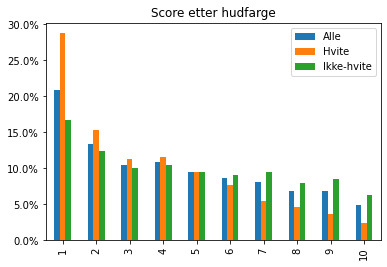

In [20]:
plot_score_dist(df, "Score etter hudfarge", df.white, "Hvite", "Ikke-hvite")

Ser at de hvite stolpene har en tilnærmet eksponesiell hellning mot venstre, der de lave risiko-scorene er (mer log-fordelt). I venstre del av grafen er de ikke-hvite stolpene konsekvent lavere enn snittet, i høyre del er det motsatt. 

### Fordeling av score etter kjønn

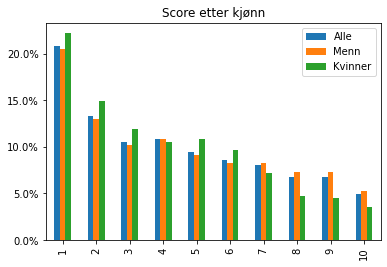

In [8]:
plot_score_dist(df, "Score etter kjønn", df.sex == 'Male', "Menn", "Kvinner")

For menn og kvinner ser vi ingen tydelig forskjell i grafene, men hvite har en tydelig mer markant brattere graf en ikke-hvite. Dette betyr at en mindre andel av hvite enn av ikke-hvite får høyere scorer.

### Fordeling av score etter gjentatt forbrytelse

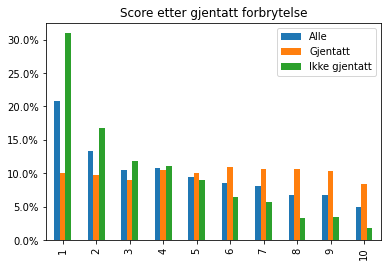

In [9]:
plot_score_dist(df, "Score etter gjentatt forbrytelse", df.actual, "Gjentatt", "Ikke gjentatt")

### Fordeling av score etter gjentatte forbrytelser, hvite

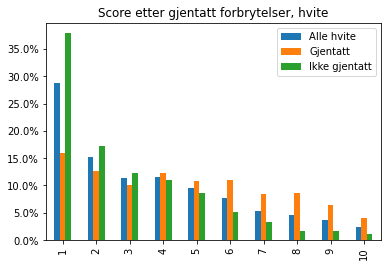

In [10]:
df_white = df[df.white]
plot_score_dist(df_white, "Score etter gjentatt forbrytelser, hvite", df_white.actual, "Gjentatt", "Ikke gjentatt", "Alle hvite")

### Fordeling av score etter gjentatte forbrytelser, ikke-hvite

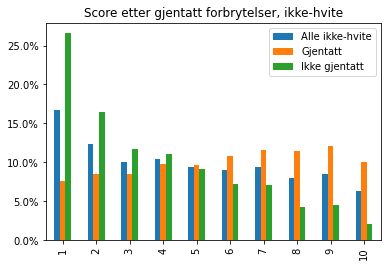

In [11]:
df_non_white = df[~df.white]
plot_score_dist(df_non_white, "Score etter gjentatt forbrytelser, ikke-hvite", df_non_white.actual, "Gjentatt", "Ikke gjentatt", "Alle ikke-hvite")

Vi ser, som ønsket, at en stor andel av de som ikke begikk lovbrudd på nytt fikk lav risiko-score. Men der score-grafen dipper nedover for høyere scorer for hvite som gjentok forbrytelsene, går den oppover blant de ikke-hvite.

# Betinget sannsynlighet
Positiv prediktiv verdi er sannsynligheten for at en person som ble predikert å begå nye lovbrudd faktisk begikk nye lovbrudd. Sensitivitet er det "motsatte": sannsynligheten for at en person som faktisk begikk nye lovbrudd ble predikert å gjøre det.

De to sannsynligheten er relatert med Bayes setning.  

In [12]:
def conditional_prob(df):
    a = pd.DataFrame({
        "Ikke gjentatt": df[~df.actual].predicted.value_counts().sort_index(),
        "Gjentatt lovbrudd": df[df.actual].predicted.value_counts().sort_index()
    }).rename({False: "Ikke predikert", True: "Predikert"}) / len(df)
    display_df_pct(a)
    pos_pred = a["Gjentatt lovbrudd"]["Predikert"] / a.loc["Predikert"].sum()
    print(f"Pos. pred. verdi: {pos_pred*100:.1f}%")
    sens = a["Gjentatt lovbrudd"]["Predikert"] / a["Gjentatt lovbrudd"].sum()
    print(f"    Sensitivitet: {sens*100:.1f}%")
    
print("Alle")
conditional_prob(df)

print("\nHvite")
conditional_prob(df[df.white])

print("\nIkke-hvite")
conditional_prob(df[~df.white])

print("\nMenn")
conditional_prob(df[df.sex == 'Male'])

print("\nKvinner")
conditional_prob(df[df.sex == 'Female'])

Alle


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,36.4%,19.0%
Predikert,15.1%,29.4%


Pos. pred. verdi: 66.0%
    Sensitivitet: 60.8%

Hvite


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,45.8%,21.1%
Predikert,12.6%,20.4%


Pos. pred. verdi: 61.8%
    Sensitivitet: 49.2%

Ikke-hvite


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,31.6%,17.9%
Predikert,16.4%,34.1%


Pos. pred. verdi: 67.5%
    Sensitivitet: 65.5%

Menn


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,34.6%,19.9%
Predikert,14.3%,31.2%


Pos. pred. verdi: 68.6%
    Sensitivitet: 61.1%

Kvinner


,Ikke gjentatt,Gjentatt lovbrudd
Ikke predikert,44.3%,15.2%
Predikert,18.7%,21.8%


Pos. pred. verdi: 53.8%
    Sensitivitet: 58.9%


Interessant blant disse tallene er at sensitiviteten blant hvite (49,2%) er mye lavere enn blant ikke-hvite (65,5%). Dette betyr at flere hvite som begikk nye lovbrudd ikke ble predikert å skulle gjøre det enn svarte.
Det er også verdt å merke at kvinner har betraktelig lavere positiv prediktiv verdi (53,8%) enn alle (66%), som betyr at flere kvinner som ble predikert å begå nye lovbrudd ikke endte med å gjøre det, enn de andre gruppene.

KAN si noe om hvorvidt falske positive er mer alvorlig enn falske negative, også i amerikansk sammenheng som i utgangspunktet er opptatt av invididet. Type 1 og type 2 feil?

# Predikere prediksjonen

Vi trener en logistisk modell for å se hvilken vekt som blir tilegnet predikatoren som indikerer "African-American".

In [13]:
from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)

Y = data["score_text"] != "Low"

model = LogisticRegression(max_iter=1000)
model.fit(X, Y)

print(model.coef_)
print(model.intercept_)

[[ 0.26841574  0.68318404 -1.34534445  1.30150177  0.47767854 -0.20805671
  -0.42133031  0.8956289  -0.80592196  0.2188144  -0.30988952]]
[-1.52332792]


Med alle vektene og bias, kalkulerer vi bias mot "African-American" som gruppe, ved å sammenlikne en idealisert person som kun har egenskapen å være "African-American" mot en person som ikke har noen egenskaper.

In [14]:
black_coef = model.coef_[0, list(X.columns).index('race_African-American')]
intercept = model.intercept_[0]

control = 1/(1+np.exp(-intercept))
racialBias = np.exp(black_coef) / (1 + control * (np.exp(black_coef) - 1))
racialBias

1.4530844530784157

Tallet forteller oss at det å være "African-American" gir en 45% større sjanse for å bli predikert å begå nye lovbrudd, enn en 

In [15]:
print(X.columns)

Index(['priors_count', 'two_year_recid', 'age_cat_Greater than 45',
       'age_cat_Less than 25', 'race_African-American', 'race_Asian',
       'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female',
       'c_charge_degree_M'],
      dtype='object')


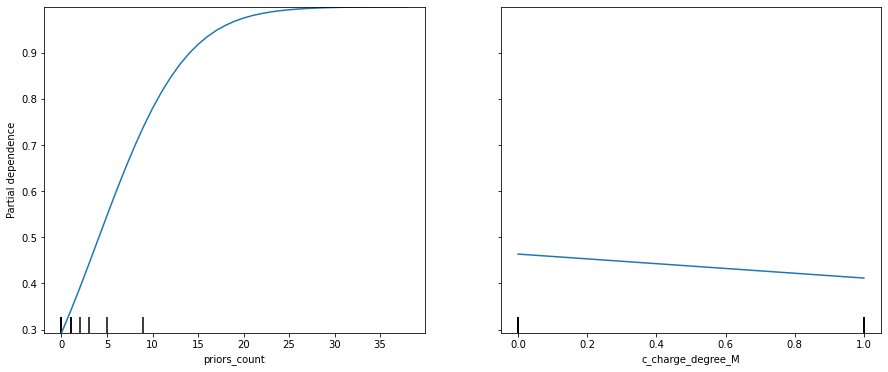

In [21]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
features = ["priors_count", "c_charge_degree_M"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)
plt.show()

Observerer hvordan scorens avhengighet av priors_count økter eksponsielt. 

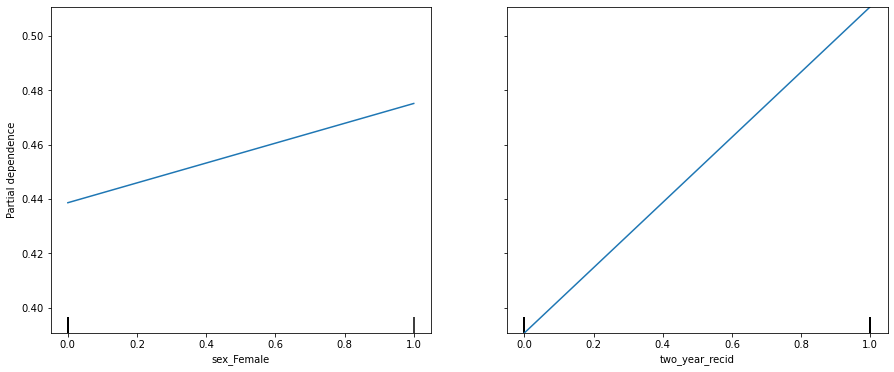

In [19]:
features = ["sex_Female", "two_year_recid"]
plot_partial_dependence(model, X, features)
plt.gcf().set_size_inches(15, 6)